In [1]:
import pickle
import numpy as np

In [2]:
# Imported to avoid matplotlib plotting error
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
with open("data/train_qa.txt", "rb") as f:  # Unpickling the train data
    train_data =  pickle.load(f)

In [4]:
with open("data/test_qa.txt", "rb") as f:   # Unpickling the test data
    test_data =  pickle.load(f)

In [5]:
print(len(train_data), len(test_data))

10000 1000


In [6]:
all_data = test_data + train_data

In [7]:
# Create a set that holds the vocab words
vocab = set()

In [8]:
for story, question , answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [9]:
# Adding two possible answers to the vocab
vocab.add('no')
vocab.add('yes')

In [10]:
vocab_len = len(vocab) + 1 # Extra space to hold a 0 for Keras's pad_sequences

In [11]:
# Find longest story and longest question
max_story_len = max([len(data[0]) for data in all_data])
max_question_len = max([len(data[1]) for data in all_data])

print(max_question_len, max_story_len)

6 156


In [12]:
# Vectorizing the data
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [13]:
# Create integer encoding for sequences of words
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [14]:
print(tokenizer.word_index)

{'john': 1, 'journeyed': 2, 'apple': 3, 'dropped': 4, 'garden': 5, 'back': 6, 'sandra': 7, 'down': 8, 'up': 9, 'bathroom': 10, 'office': 11, 'to': 12, 'moved': 13, 'grabbed': 14, 'discarded': 15, 'is': 16, 'daniel': 17, 'football': 18, 'put': 19, '.': 20, 'travelled': 21, '?': 22, 'took': 23, 'the': 24, 'no': 25, 'got': 26, 'kitchen': 27, 'went': 28, 'hallway': 29, 'bedroom': 30, 'picked': 31, 'left': 32, 'there': 33, 'yes': 34, 'milk': 35, 'mary': 36, 'in': 37}


In [15]:
# Function for vectorizing
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
     
    # X = STORIES
    X = []    
    # Xq = QUERY or QUESTION
    Xq = []    
    # Y = CORRECT ANSWER (Yes/No)
    Y = []
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]        
        # Empty matrix
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Return the padded sequences
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [16]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [17]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [18]:
# Creating the model

In [19]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

In [20]:
# Placeholders with shape = (max_len, batch_size)
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [21]:
# Re-defining a new variable for vocab_len
vocab_size = vocab_len

In [22]:
# Input Encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))

In [23]:
# Input Encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=max_question_len))
input_encoder_c.add(Dropout(0.3))

In [24]:
# Question Encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(Dropout(0.3))

In [25]:
# Encode to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [26]:
# Use dot product to compute the match between first input vector seq and the query
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match = Activation('softmax')(match)

In [27]:
# Add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])
response = Permute((2, 1))(response)

In [28]:
# Concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])

In [29]:
# Reduce with RNN (LSTM)
answer = LSTM(32)(answer)

In [30]:
# Regularization with Dropout
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) 

In [31]:
# Output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [32]:
# Build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [34]:
# Training the model
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=150,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/150
313/313 [==============================] - 6s 11ms/step - loss: 0.9207 - accuracy: 0.4942 - val_loss: 0.7004 - val_accuracy: 0.4970
Epoch 2/150
313/313 [==============================] - 3s 9ms/step - loss: 0.7045 - accuracy: 0.5064 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 3/150
313/313 [==============================] - 3s 9ms/step - loss: 0.6961 - accuracy: 0.4990 - val_loss: 0.6968 - val_accuracy: 0.5030
Epoch 4/150
313/313 [==============================] - 3s 9ms/step - loss: 0.6955 - accuracy: 0.4961 - val_loss: 0.6935 - val_accuracy: 0.4970
Epoch 5/150
313/313 [==============================] - 3s 9ms/step - loss: 0.6952 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4970
Epoch 6/150
313/313 [==============================] - 3s 9ms/step - loss: 0.6943 - accuracy: 0.5046 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 7/150
313/313 [==============================] - 3s 9ms/step - loss: 0.6937 - accuracy: 0.5067 - val_loss: 0.6938 - val_accuracy: 0.497

Epoch 58/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3769 - accuracy: 0.8259 - val_loss: 0.4372 - val_accuracy: 0.8000
Epoch 59/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3713 - accuracy: 0.8323 - val_loss: 0.4360 - val_accuracy: 0.7900
Epoch 60/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3769 - accuracy: 0.8278 - val_loss: 0.4452 - val_accuracy: 0.7960
Epoch 61/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3733 - accuracy: 0.8272 - val_loss: 0.4333 - val_accuracy: 0.7980
Epoch 62/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3686 - accuracy: 0.8315 - val_loss: 0.4663 - val_accuracy: 0.7890
Epoch 63/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3719 - accuracy: 0.8283 - val_loss: 0.4648 - val_accuracy: 0.7960
Epoch 64/150
313/313 [==============================] - 3s 9ms/step - loss: 0.3663 - accuracy: 0.8338 - val_loss: 0.4416 - val_accuracy:

313/313 [==============================] - 3s 9ms/step - loss: 0.2655 - accuracy: 0.8896 - val_loss: 0.4699 - val_accuracy: 0.8140
Epoch 115/150
313/313 [==============================] - 3s 9ms/step - loss: 0.2531 - accuracy: 0.8940 - val_loss: 0.4843 - val_accuracy: 0.8100
Epoch 116/150
313/313 [==============================] - 3s 9ms/step - loss: 0.2627 - accuracy: 0.8925 - val_loss: 0.4644 - val_accuracy: 0.8120
Epoch 117/150
313/313 [==============================] - 3s 9ms/step - loss: 0.2574 - accuracy: 0.8916 - val_loss: 0.4734 - val_accuracy: 0.8190
Epoch 118/150
313/313 [==============================] - 3s 9ms/step - loss: 0.2545 - accuracy: 0.8923 - val_loss: 0.4580 - val_accuracy: 0.8200
Epoch 119/150
313/313 [==============================] - 3s 9ms/step - loss: 0.2520 - accuracy: 0.8921 - val_loss: 0.4764 - val_accuracy: 0.8130
Epoch 120/150
313/313 [==============================] - 3s 9ms/step - loss: 0.2551 - accuracy: 0.8921 - val_loss: 0.4940 - val_accuracy: 0.8140

In [35]:
# # Saving the model
filename = 'model/chatbot.h5'
model.save(filename)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


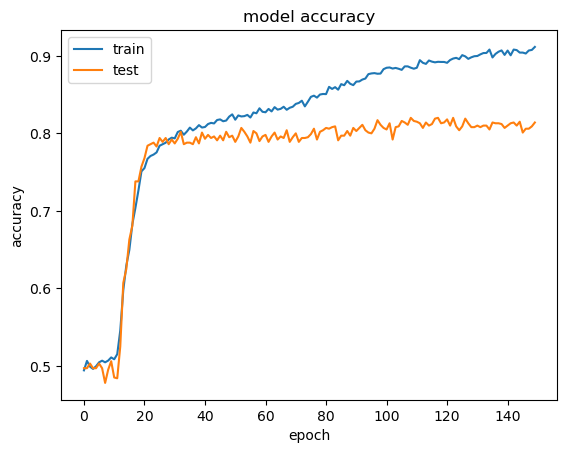

In [36]:
# # Plotting the training history
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.show()

In [37]:
# Loading the trained model
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [38]:
# First test data
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [39]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [40]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [41]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [42]:
# Testing for first test data
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

# Generated prediction by model
print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.9999888


In [43]:
def predict_ans(my_story, my_question, my_ans):
    my_story.split()
    my_question.split()
    
    mydata = [(my_story.split(), my_question.split(), my_ans)]
    
    my_story, my_ques, my_ans = vectorize_stories(mydata)
    
    pred_results = model.predict(([my_story, my_ques]))
    val_max = np.argmax(pred_results[0])

    for key, val in tokenizer.word_index.items():
        if val == val_max:
            k = key

    print("Predicted answer is: ", k)
    print("Probability of certainty was: ", pred_results[0][val_max])

In [44]:
# Writing own story, query and answer

# Use words only from the vocab
print(vocab)

{'John', 'journeyed', 'apple', 'dropped', 'garden', 'back', 'Sandra', 'down', 'up', 'bathroom', 'office', 'to', 'moved', 'grabbed', 'discarded', 'Is', 'Daniel', 'football', 'put', '.', 'travelled', '?', 'took', 'the', 'no', 'got', 'kitchen', 'went', 'hallway', 'bedroom', 'picked', 'left', 'there', 'yes', 'milk', 'Mary', 'in'}


In [45]:
# In original data there are whitespaces in periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_question = "Is the football in the garden ?"
my_ans = 'yes'

predict_ans(my_story, my_question, my_ans)

Predicted answer is:  yes
Probability of certainty was:  0.94849217
